# Applied Data Science Capstone


1. Get Initial Data
    * Scrape Toronto postal code data from Wikipedia
    * Get geo location for data set
2. Seperate data into subset for more reliable clustering
    * Full Toronto Dataset
    * Downtown subset
    * Uptown subset
3. Get Venue Data from Foursquare API
    * Encode
    * Find most common venues
4. Determine optimal cluster count for the 3 data sets
    * Apply Elbow method
    * Apply silhouette method
5. Build Clusters
6. Map Clusters
7. Examine Clusters

In [151]:
#Libraries
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import geocoder
from datetime import date
import json
from pandas.io.json import json_normalize
import folium
from geopy.geocoders import Nominatim 
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans

In [84]:
#Foursquare
CLIENT_ID = 'PP1YWJZLGPAOTV0JRPJ2COQZ0BLXXAXR1WVR2M12OHN3WPIE' # your Foursquare ID
CLIENT_SECRET = '3WHMP4NQPMAAAURF5FGSVT2G43UDH3TTQJDGWGJTWMILA3TO' # your Foursquare Secret
VERSION = date.today().strftime("%Y%m%d")
LIMIT = 100 # A default Foursquare API limit value

# 1.) Get Initial Data
### Data from Wikipedia scrape and provided geo location csv

In [17]:
#Id table with data
response = requests.get(url="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(response.content, 'html.parser')
tab = soup.find("table")

In [35]:
#Place table data into lists
pcode=[]
borough=[]
hood=[]

rows = tab.find_all('tr')

for row in rows:
    cells = row.find_all('td')
    
    if len(cells) > 1:
        p=cells[0]
        pcode.append(p.text.strip())
        
        b=cells[1]
        borough.append(b.text.strip())
        
        h=cells[2]
        hood.append(h.text.strip())


In [36]:
#Create dataframe
df = pd.DataFrame({'Postal Code':pcode, 'Borough':borough, 'Neighborhood':hood})
df.shape

(180, 3)

In [39]:
dropindex = df[df['Borough']=='Not assigned'].index
df.drop(dropindex,inplace=True)
df.shape

(103, 3)

In [40]:
df.head()

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [65]:
#Get geo data from csv because google geocoder isnt free (lame)
geo_df = pd.read_csv('https://cocl.us/Geospatial_data', index_col='Postal Code')
geo_df.head()

,Latitude,Longitude
Postal Code,,
M1B,43.806686,-79.194353
M1C,43.784535,-79.160497
M1E,43.763573,-79.188711
M1G,43.770992,-79.216917
M1H,43.773136,-79.239476


In [88]:
#Join wiki data and geo data
df_postcode = df.groupby(['Postal Code', 'Borough'])['Neighborhood'].apply(', '.join).reset_index()
toronto_df = df_postcode.join(geo_df, on='Postal Code') 
print("Shape:",toronto_df.shape)
toronto_df.head()

Shape: (103, 5)


,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


# 2.) Seperate Data into subsets

## Create a 'Downtown' and an 'Uptown' seperation to the data

In [357]:
#downtown_df = toronto_df.loc[toronto_df['Borough'].str.contains("Toronto") | toronto_df['Neighborhood'].str.contains("Toronto")]
#uptown_df = toronto_df.loc[~toronto_df['Borough'].str.contains("Toronto") & ~toronto_df['Neighborhood'].str.contains("Toronto")]
downtown_df = toronto_df.loc[toronto_df['Borough'].str.contains("Toronto")]
uptown_df = toronto_df.loc[~toronto_df['Borough'].str.contains("Toronto")]
print("Downtown data shape:",downtown_df.shape)
print("Uptown data shape:",uptown_df.shape)

Downtown data shape: (39, 5)
Uptown data shape: (64, 5)


In [358]:
address = 'Toronto, Ontario, Canada'

geolocator = Nominatim(user_agent="ca_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates are {}, {}.'.format(latitude, longitude))

The geograpical coordinates are 43.6534817, -79.3839347.


# Neighborhoods in Toronto

In [73]:
map_can = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Borough'], toronto_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_can)  
    
map_can

# Downtown and Uptown Toronto Seperations

In [222]:
from folium import Map, FeatureGroup, Marker, LayerControl

In [359]:
map_can = folium.Map(location=[latitude, longitude], zoom_start=11)

dt = FeatureGroup(name='Downtown')
ut = FeatureGroup(name='Uptown')

# add markers to map
for lat, lng, borough, neighborhood in zip(downtown_df['Latitude'], downtown_df['Longitude'], downtown_df['Borough'], downtown_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(dt)  
    
for lat, lng, borough, neighborhood in zip(uptown_df['Latitude'], uptown_df['Longitude'], uptown_df['Borough'], uptown_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(ut)      

map_can.add_child(dt)
map_can.add_child(ut)
map_can.add_child(folium.map.LayerControl())
map_can

# 3.)  Get Venue Data from Foursquare API
### Expand  dataset to include venue data

In [90]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [91]:
toronto_venues = getNearbyVenues(names=toronto_df['Neighborhood'],
                                   latitudes=toronto_df['Latitude'],
                                   longitudes=toronto_df['Longitude']
                                  )

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

In [360]:
print("Venue Data Shape:",toronto_venues.shape)
print("Venue Categories:", len(toronto_venues['Venue Category'].unique()))

Venue Data Shape: (2118, 7)
Venue Categories: 271


In [361]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,5,5,5,5,5,5
"Alderwood, Long Branch",8,8,8,8,8,8
"Bathurst Manor, Wilson Heights, Downsview North",22,22,22,22,22,22
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",26,26,26,26,26,26
...,...,...,...,...,...,...
"Willowdale, Willowdale East",34,34,34,34,34,34
"Willowdale, Willowdale West",5,5,5,5,5,5
Woburn,4,4,4,4,4,4


### Encoding

In [396]:
# one hot encoding
tor_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
tor_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

fixed_columns = [tor_onehot.columns[-1]] + list(tor_onehot.columns[:-1])
tor_onehot = tor_onehot[fixed_columns]

In [397]:
tor_group = tor_onehot.groupby('Neighborhood').mean().reset_index()
tor_group.shape

(96, 271)

### Most Common Venues

In [600]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [601]:
num_top_venues = 10

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
        columns.append("V:{}".format(ind+1))

# create a new dataframe
top_venues = pd.DataFrame(columns=columns)
top_venues['Neighborhood'] = tor_group['Neighborhood']

for ind in np.arange(tor_group.shape[0]):
    top_venues.iloc[ind, 1:] = return_most_common_venues(tor_group.iloc[ind, :], num_top_venues)

top_venues.shape

(96, 11)

#### Most Common Venues in Downtown and Uptown

In [602]:
columns = ['Neighborhood']
dt_ven = pd.DataFrame(columns=columns)
dt_ven['Neighborhood'] = downtown_df['Neighborhood']
dt_ven = dt_ven.join(tor_group.set_index('Neighborhood'), on='Neighborhood')
ut_ven = pd.DataFrame(columns=columns)
ut_ven['Neighborhood'] = uptown_df['Neighborhood']
ut_ven = ut_ven.join(tor_group.set_index('Neighborhood'), on='Neighborhood')

print("Downtown Vendor:", dt_ven.shape)
print("Uptown Vendor:", ut_ven.shape)

Downtown Vendor: (39, 271)
Uptown Vendor: (64, 271)


In [603]:
print(ut_ven.shape)
ut_ven.dropna(inplace=True)
print(ut_ven.shape)

(64, 271)
(61, 271)


In [604]:
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
        columns.append("V:{}".format(ind+1))

dt_top = pd.DataFrame(columns=columns)
dt_top['Neighborhood'] = dt_ven['Neighborhood']

for ind in np.arange(dt_ven.shape[0]):
    dt_top.iloc[ind, 1:] = return_most_common_venues(dt_ven.iloc[ind, :], num_top_venues)

dt_top.shape

(39, 11)

In [605]:
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
        columns.append("V:{}".format(ind+1))

ut_top = pd.DataFrame(columns=columns)
ut_top['Neighborhood'] = ut_ven['Neighborhood']

for ind in np.arange(ut_ven.shape[0]):
    ut_top.iloc[ind, 1:] = return_most_common_venues(ut_ven.iloc[ind, :], num_top_venues)

ut_top.shape

(61, 11)

# 4.) Determine Optimal Cluster counts

### Using entire data set and two subset data sets for downtown and uptown

In [606]:
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer

### Full Toronto data set

In [607]:
ssd = []
v_clus = tor_group.drop('Neighborhood', 1)

K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k, random_state=0).fit(v_clus)
    ssd.append(km.inertia_)

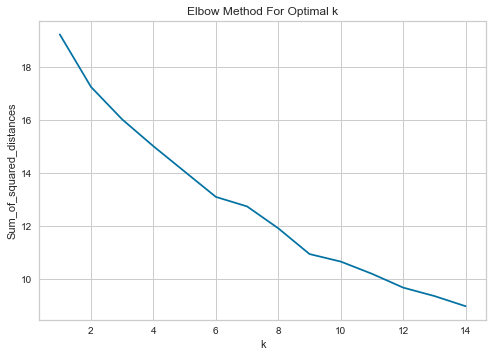

In [608]:
plt.plot(K, ssd, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

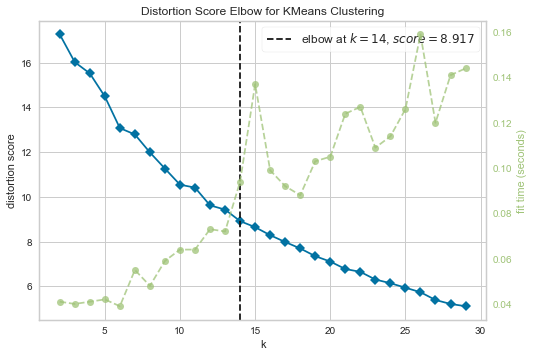

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [609]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(v_clus)       
visualizer.show()
#Elbow at 7

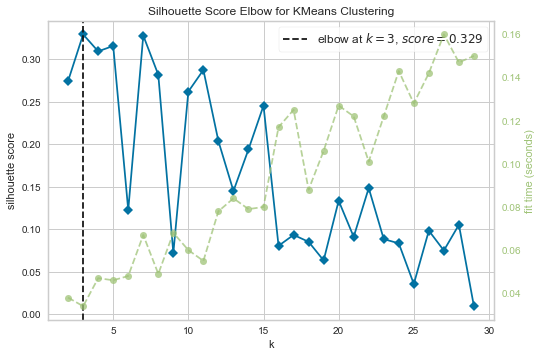

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [610]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,30),metric='silhouette', timings= True)
visualizer.fit(v_clus)       
visualizer.show()
#Max at 7

In [611]:
tor_kclus = 7

### Downtown

In [612]:
#Downtown cluster
ssd = []
dt_clus = dt_ven.drop('Neighborhood', 1)

K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k, random_state=0).fit(dt_clus)
    ssd.append(km.inertia_)


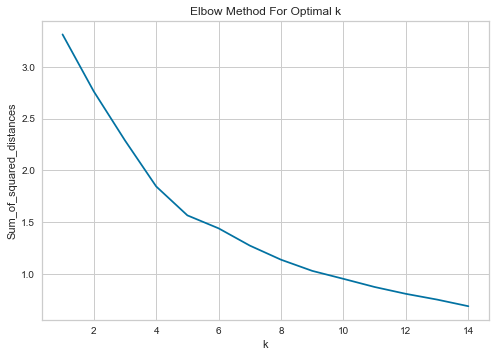

In [613]:
plt.plot(K, ssd, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()
#Elbow at 4

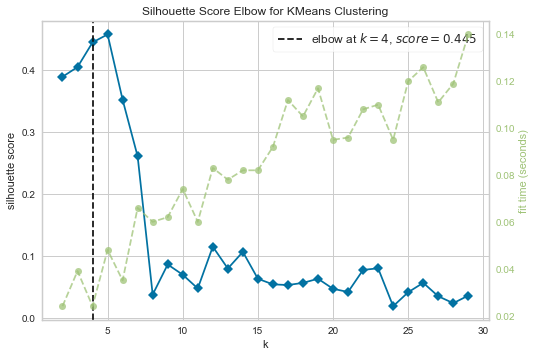

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [614]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,30),metric='silhouette', timings= True)
visualizer.fit(dt_clus)       
visualizer.show()
#Max at 2

In [615]:
dt_kclus = 4

### Uptown

In [616]:
ut_clus = ut_ven.drop('Neighborhood', 1)
#ut_clus.dropna(inplace=True)
ut_clus.shape

(61, 270)

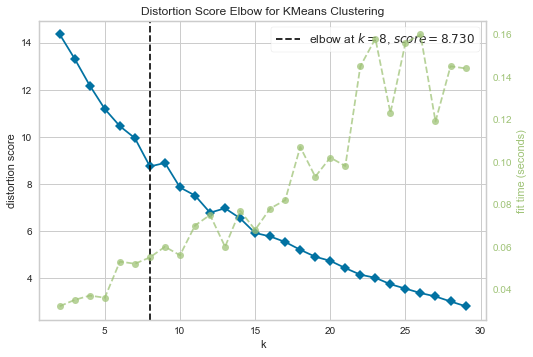

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [617]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(ut_clus)       
visualizer.show()
#Elbow at 8?

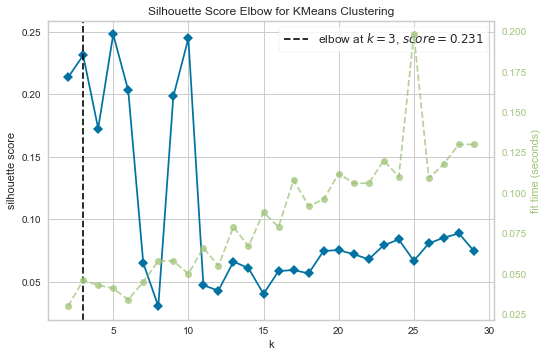

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [618]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,30),metric='silhouette', timings= True)
visualizer.fit(ut_clus)       
visualizer.show()
#Max at 8

In [619]:
ut_kclus = 8

# 5.) Build Clusters

In [620]:
#Full Dataset Clustering
kmeans = KMeans(n_clusters=tor_kclus, random_state=0, n_init=12).fit(v_clus)
top_venues.insert(0, 'Cluster Labels', kmeans.labels_)

In [621]:
#Downtown
dt_kmeans = KMeans(n_clusters=dt_kclus, random_state=0, n_init=12).fit(dt_clus)
dt_top.insert(0, 'Cluster Labels', dt_kmeans.labels_)

In [622]:
#Uptown
ut_kmeans = KMeans(n_clusters=ut_kclus, random_state=0, n_init=12).fit(ut_clus)
ut_top.insert(0, 'Cluster Labels', ut_kmeans.labels_)

In [632]:
#Full Toronto
toronto_vdf = toronto_df
toronto_vdf = toronto_vdf.join(top_venues.set_index('Neighborhood'), on='Neighborhood')
#Downtown seperation
downtown_vdf = downtown_df
downtown_vdf = downtown_vdf.join(dt_top.set_index('Neighborhood'), on='Neighborhood')
#Uptown seperation
uptown_vdf = uptown_df
uptown_vdf = uptown_vdf.join(ut_top.set_index('Neighborhood'), on='Neighborhood')

print("Full Toronto df:",toronto_vdf.shape)
print("Downtown df:",downtown_vdf.shape)
print("Uptown df:",uptown_vdf.shape)

Full Toronto df: (103, 16)
Downtown df: (39, 16)
Uptown df: (78, 16)


In [633]:
#Clean up NA and cluster label types
toronto_vdf.dropna(inplace=True)
toronto_vdf['Cluster Labels'] = toronto_vdf['Cluster Labels'].astype('int64')
downtown_vdf.dropna(inplace=True)
downtown_vdf['Cluster Labels'] = downtown_vdf['Cluster Labels'].astype('int64')
uptown_vdf.dropna(inplace=True)
uptown_vdf['Cluster Labels'] = uptown_vdf['Cluster Labels'].astype('int64')


# 6.) Map Clusters
<br>

## Full Toronto Clustered

In [634]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_vdf['Latitude'], toronto_vdf['Longitude'], toronto_vdf['Neighborhood'], toronto_vdf['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Downtown Clustered

In [635]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(downtown_vdf['Latitude'], downtown_vdf['Longitude'], downtown_vdf['Neighborhood'], downtown_vdf['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Uptown Clustered

In [636]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(uptown_vdf['Latitude'], uptown_vdf['Longitude'], uptown_vdf['Neighborhood'], uptown_vdf['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# 7.) Examine Clusters

In [628]:
from collections import Counter

## Occurence count in cluster

#### To better understand the clustering scheme, the next three code cells print out: <br>
1. The cluster number 
2. The top 5 most common venue types in that cluster 
3. The count of that venue type in that cluster 

### Full Toronto Dataset

In [631]:
tor_lst={}
for x in range(0, tor_kclus):
    d = pd.DataFrame(toronto_vdf.loc[toronto_vdf['Cluster Labels'] == x, toronto_vdf.columns[[1] + list(range(6, toronto_vdf.shape[1]))]])
    lst=[]
    for i in range(0, d.shape[0]):
        for j in range(1, d.shape[1]):
            lst.append(d.iat[i,j])

    cnt=Counter(lst)   
    tor_lst[x] = cnt.most_common(5)
    print("Cluster:",x,tor_lst[x]) 

Cluster: 0 [('Diner', 7), ('Discount Store', 7), ('Distribution Center', 7), ('Dog Run', 7), ('Park', 7)]
Cluster: 1 [('Coffee Shop', 45), ('Discount Store', 31), ('Café', 31), ('Restaurant', 29), ('Diner', 21)]
Cluster: 2 [('Baseball Field', 2), ('Drugstore', 2), ('Discount Store', 2), ('Distribution Center', 2), ('Dog Run', 2)]
Cluster: 3 [('Fast Food Restaurant', 1), ('Donut Shop', 1), ('Dim Sum Restaurant', 1), ('Diner', 1), ('Discount Store', 1)]
Cluster: 4 [('Jewelry Store', 1), ("Women's Store", 1), ('Donut Shop', 1), ('Diner', 1), ('Discount Store', 1)]
Cluster: 5 [('Bakery', 1), ("Women's Store", 1), ('Donut Shop', 1), ('Diner', 1), ('Discount Store', 1)]
Cluster: 6 [('Bus Line', 2), ('Park', 2), ('Doner Restaurant', 2), ('Diner', 2), ('Discount Store', 2)]


## Downtown

In [629]:
dt_lst={}
for x in range(0, dt_kclus):
    d = pd.DataFrame(downtown_vdf.loc[downtown_vdf['Cluster Labels'] == x, downtown_vdf.columns[[1] + list(range(6, downtown_vdf.shape[1]))]])
    lst=[]
    for i in range(0, d.shape[0]):
        for j in range(1, d.shape[1]):
            lst.append(d.iat[i,j])

    cnt=Counter(lst)   
    dt_lst[x] = cnt.most_common(5)
    print("Cluster:",x,dt_lst[x]) 

Cluster: 0 [('Diner', 4), ('Discount Store', 4), ('Distribution Center', 4), ('Dog Run', 4), ('Trail', 3)]
Cluster: 1 [('Garden', 1), ('Pool', 1), ("Women's Store", 1), ('Dog Run', 1), ('Dessert Shop', 1)]
Cluster: 2 [('Coffee Shop', 26), ('Café', 23), ('Restaurant', 19), ('Italian Restaurant', 17), ('Bakery', 12)]
Cluster: 3 [('Tennis Court', 1), ('Restaurant', 1), ("Women's Store", 1), ('Dessert Shop', 1), ('Dim Sum Restaurant', 1)]


## Uptown

In [637]:
ut_lst={}
for x in range(0, ut_kclus):
    d = pd.DataFrame(uptown_vdf.loc[uptown_vdf['Cluster Labels'] == x, uptown_vdf.columns[[1] + list(range(6, uptown_vdf.shape[1]))]])
    lst=[]
    for i in range(0, d.shape[0]):
        for j in range(1, d.shape[1]):
            lst.append(d.iat[i,j])

    cnt=Counter(lst)   
    ut_lst[x] = cnt.most_common(5)
    print("Cluster:",x,ut_lst[x]) 

Cluster: 0 [('Baseball Field', 2), ('Drugstore', 2), ('Discount Store', 2), ('Distribution Center', 2), ('Dog Run', 2)]
Cluster: 1 [('Diner', 7), ('Discount Store', 7), ('Pizza Place', 7), ('Intersection', 6), ('Dim Sum Restaurant', 5)]
Cluster: 2 [('Playground', 1), ("Women's Store", 1), ('Donut Shop', 1), ('Dim Sum Restaurant', 1), ('Diner', 1)]
Cluster: 3 [('Discount Store', 35), ('Bank', 21), ('Grocery Store', 19), ('Park', 19), ('Athletics & Sports', 18)]
Cluster: 4 [('Bakery', 1), ("Women's Store", 1), ('Donut Shop', 1), ('Diner', 1), ('Discount Store', 1)]
Cluster: 5 [('Park', 6), ('Doner Restaurant', 5), ('Diner', 5), ('Discount Store', 5), ('Distribution Center', 5)]
Cluster: 6 [('Jewelry Store', 1), ("Women's Store", 1), ('Donut Shop', 1), ('Diner', 1), ('Discount Store', 1)]
Cluster: 7 [('Motel', 1), ('American Restaurant', 1), ("Women's Store", 1), ('Doner Restaurant', 1), ('Dim Sum Restaurant', 1)]
